In [1]:
%matplotlib inline


============================
Underfitting vs. Overfitting
============================

![overfitimages](https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/overfitting-logreg-ex.png)
This example demonstrates the problems of underfitting and overfitting and
how we can use linear regression with polynomial features to approximate
nonlinear functions. The plot shows the function that we want to approximate,
which is a part of the cosine function. In addition, the samples from the
real function and the approximations of different models are displayed. The
models have polynomial features of different degrees. We can see that a
linear function (polynomial with degree 1) is not sufficient to fit the
training samples. This is called **underfitting**. A polynomial of degree 4
approximates the true function almost perfectly. However, for higher degrees
the model will **overfit** the training data, i.e. it learns the noise of the
training data.
We evaluate quantitatively **overfitting** / **underfitting** by using
cross-validation. We calculate the mean squared error (MSE) on the validation
set, the higher, the less likely the model generalizes correctly from the
training data.


# Import libraries

Here we are going to import a couple of useful libraries. First let's import numpy and matplotlib. Numpy is a scientific computing library similar to Matlab, and matplotlib gives us Matlab-esque plotting capabilities.

Next we will import scikit-learn libraries to construct arbitrary model pipelines, perform basic feature engineering, train/infer regression tasks, and validate our model.

In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline                 # Super useful for keeping models clean
from sklearn.preprocessing import PolynomialFeatures  # Generate more features from existing data
from sklearn.linear_model import LinearRegression     # Simplest Regression model
from sklearn.model_selection import cross_val_score   # Tells us how well our model performed

Automatically created module for IPython interactive environment


# Configure environment

In [3]:
np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

# Generate some data
Just a simple cosine function with noise added to it :)

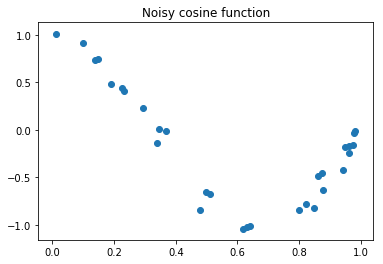

In [8]:
true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.scatter(X,y)
plt.title("Noisy cosine function")
plt.show()

# Run the experiment
Let's go ahead an run a simple experiment to showcase underfitting and overfitting. Here we keep adding polynomial degrees to our model until it is overfit.

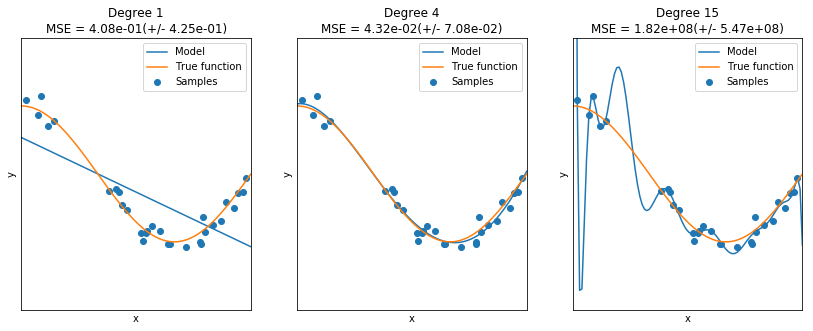

In [10]:
plt.figure(figsize=(14, 5))

for i in range(len(degrees)):
    
    # Pretty Plotting boiler plate
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

# Understanding the model

## Feature engineering
[Fun story on feature engineering](http://blog.kaggle.com/2016/02/26/genentech-cervical-cancer-screening-winners-interview-1st-place-michael-giulio/)

Feature engineering is the process of adding and removing (feature selection) features given prior knowledge of the dataset itself. For example, suppose we have categorical features such as "positive", "negative", and "neutral": these can either be encoded as (0,1,2), (+1,-1,0), or via one-hot encoding. Depending on the task, choosing the correct feature representation can have HUGE effects on the model performance. 

Conversely we can remove features or, more accurately, select more important features. This process of feature selection is usually based on some statistical model and has the following benefits:
* simplification of models to make them easier to interpret by researchers/users,[1]
* shorter training times,
* avoids the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality),
* enhanced generalization by reducing overfitting[2] (formally, reduction of variance[1])

## What we did: Polynomial Features
Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

```
 polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
```

## So what is the difference between Data Science and Machine Learning?
Simply put, machine learning is the process of describing mathematical models that are able to learn (e.g. linear regression with gradient descent, extreme gradient boosting trees, LASSO, and neural nets with the back propagation algorithm), whereas data science/data mining is how we use these models to solve a particular task given data sources.

## Supervised Classification vs Supervised Regression

Supervised models have both training data $X$ and training labels $y$. Unsupervised learning models do not have training labels $y$.

Classification tasks attempt to assign binary or categorical labels (multiclass) to data. For example, {spam, ham}, {fraud, not-fraud, unsure}. On the other hand, regression tasks try to infer values on $\mathbb{R}$. For example, predicting the true value of a home based on input features.

## What we did: Ordinary Linear Least Squares Regression
Basic formulation of linear least squares regression.
$$min ||Ax-y||^2 + reg(x) \quad s.t. \quad x\in \mathbb{R}^n$$

The regularization parameter gives us control over the sparsity of our learned model by imposing penalty conditions to the learning process. However, ordinary least squares, OLS, has no regularization.

```
linear_regression = LinearRegression()
```

## Model Validation
This is a critical part of any successful model pipeline, and requires us to specify both a training/testing data set and a scoring function. Picking this function is extremely important and you can find more information [here](http://scikit-learn.org/stable/modules/model_evaluation.html)

## Cross Validation
Note there is a huge fundamental problem with our current pipeline, we use all of our data for both training and testing. What happens if we get data we haven't seen before? Can we trust our score generalizes to unknown data? 

A better method is to run a cross validation scheme like K-Fold, Leave One Out, Shuffle and Split, etc. You can find a detailed discussion [here](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).
![Example of K-fold CV](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

## Model validation neat statistical trick
you can verify that your model is in the noise floor if, given sufficient conditions, 
$$\sigma < \frac{1}{2\sqrt{n}}$$ where $n$ is the number of training samples